In [357]:
library(Seurat)
library(org.Hs.eg.db)
library(clusterProfiler)
library(patchwork)
library(dplyr)
library(RColorBrewer)
library(ggplot2)
library(cowplot)
library(ggpubr)
library(readr)
library(tidyr)
library(ggforce)
library(pals)
library(pheatmap)
library(scales)
library(ggthemes)
library(clustree)
library(ComplexHeatmap)
library(circlize)
library(ggrastr)
library(ggrepel)
library(purrr)
library(reshape2)
library(scatterpie)

In [3]:
setwd("/mnt/public3/chaohy/pancancer/fig3/")

In [4]:
rds <- readRDS("/mnt/public3/chaohy/pancancer/fig3/Ductal0115_umap.rds")

An object of class Seurat 
210150 features across 83829 samples within 3 assays 
Active assay: SCT (78746 features, 0 variable features)
 2 other assays present: RNA, integrated
 2 dimensional reductions calculated: pca, umap

In [ ]:
# DefaultAssay(rds) <- "integrated"
# rds <- FindNeighbors(rds, dims = 1:30)
# rds <- FindClusters(rds, resolution = 0.8)
# rds <- RunUMAP(rds, dims = 1:30, n.neighbors = 50)
# DefaultAssay(rds) <- "SCT"

In [14]:
# saveRDS(rds, file = "/mnt/public3/chaohy/pancancer/fig3/Ductal0115_umap.rds")

In [5]:
legend_labels <- c("Ductal cell 1", "Ductal cell 2", "Ductal cell 3", "Ductal cell 4", "Ductal cell 5", "Ductal cell 6", "HM", "PT", "NT")
legend_colors <- c("#d95f02", "#66a61e", "#7570b3", "#e7298a", "#1b9e77", "#e6ab02", "#AD352E", "#D17318", "#2a71a9")
DCcol <- setNames(legend_colors, legend_labels)

png 
  2

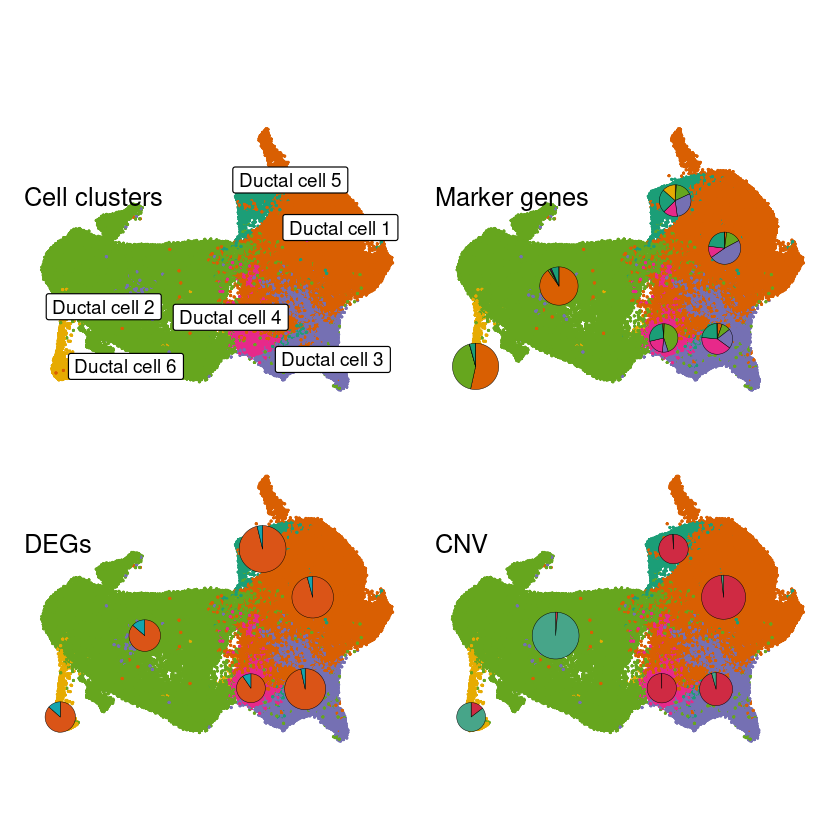

In [20]:
# 计算cluster的中心坐标
cell_eb <- data.frame(rds@reductions[["umap"]]@cell.embeddings[,1:2], cluster=as.character(rds$major_cluster), stringsAsFactors = F)
colnames(cell_eb) <- c('x','y','major_cluster')
coords <- cell_eb %>% group_by(major_cluster) %>% dplyr::summarise(x=median(x), y=median(y), .groups = "keep") %>% as.data.frame

# 计算每种Course的细胞数量
table(rds$major_cluster, rds$Course) %>% as.data.frame.matrix() -> majorCluster_Course
majorCluster_Course$SumCell <- rowSums(majorCluster_Course) %>% scales::rescale(c(0.4,0.9))+0.4
majorCluster_Course[,1:3] <- majorCluster_Course[,1:3] * 100 / rowSums(majorCluster_Course[,1:3])
majorCluster_Course$major_cluster <- rownames(majorCluster_Course)
majorCluster_Course <- merge(majorCluster_Course, coords, by="major_cluster")

# 计算marker gene的表达量
markersGene <- c("FXYD2", "HSPA1B", "MUC1", "KRT17", "EPCAM", "MKI67")
markersGeneExp <- AverageExpression(rds, features = markersGene,group.by = 'major_cluster', assays = 'SCT')$SCT %>% t() %>% as.data.frame()
markersGeneExp$SumExp <- rowSums(markersGeneExp) %>% scales::rescale(c(0.4,0.9))+0.4
markersGeneExp[,1:6] <- markersGeneExp[,1:6] * 100 / rowSums(markersGeneExp[,1:6])
markersGeneExp$major_cluster <- rownames(markersGeneExp)
markersGeneExp <- merge(markersGeneExp, coords, by="major_cluster")

# 计算每种CNV的细胞数量
table(rds$major_cluster, rds$CNV_result) %>% as.data.frame.matrix() -> majorCluster_CNV
majorCluster_CNV$SumCell <- rowSums(majorCluster_CNV) %>% scales::rescale(c(0.4,0.9))+0.4
majorCluster_CNV[,1:2] <- majorCluster_CNV[,1:2] * 100 / rowSums(majorCluster_CNV[,1:2])
majorCluster_CNV$major_cluster <- rownames(majorCluster_CNV)
majorCluster_CNV <- merge(majorCluster_CNV, coords, by="major_cluster")


# 计算每种cluster的PCs和LncRNA的数量
read.csv("/mnt/public3/chaohy/pancancer/fig3/Major_markerGenes.csv", header=T) -> major_cluster_DEGs
read.table("/mnt/public3/chaohy/pancancer/fig1c/gene.bed", sep="\t", header=F) -> gene_bed
gene_bed[gene_bed$V5=="lncRNA",] -> gene_bed_lncRNA
gene_bed[gene_bed$V5=="protein_coding",] -> gene_bed_PC
major_cluster_DEGs[major_cluster_DEGs$p_val_adj < 0.05,] %>%  dplyr::filter(pct.1>0.2 & pct.2<pct.1) -> major_cluster_DEGs
major_cluster_DEGs[major_cluster_DEGs$gene %in% gene_bed_PC$V4,]  -> major_cluster_PCs
major_cluster_DEGs[major_cluster_DEGs$gene %in% gene_bed_lncRNA$V4,] -> major_cluster_Lnc
major_cluster_PCs %>% group_by(cluster) %>% dplyr::summarise(PCs=n()) -> major_cluster_PCs
major_cluster_Lnc %>% group_by(cluster) %>% dplyr::summarise(Lnc=n()) -> major_cluster_Lnc
merge(major_cluster_PCs, major_cluster_Lnc, by="cluster") -> PCs_Lnc_numStat
PCs_Lnc_numStat$GeneSum <- rowSums(PCs_Lnc_numStat[,2:3]) %>% scales::rescale(c(0.4,0.9))+0.4    
PCs_Lnc_numStat[,2:3] <- PCs_Lnc_numStat[,2:3] * 100 / rowSums(PCs_Lnc_numStat[,2:3])
colnames(PCs_Lnc_numStat) <-c("major_cluster","PCs","Lnc","GeneSum")
PCs_Lnc_numStat <- merge(PCs_Lnc_numStat, coords, by="major_cluster")


# 绘制图形
ggplot(data=cell_eb, aes(x,y)) + geom_point_rast(aes(colour = factor(major_cluster)), size=0.1) +
  scale_color_manual(values = alpha(DCcol)) + 
  theme_pubr() +
  NoAxes() + theme(legend.position = "none") -> p

p + geom_label_repel(data = majorCluster_Course, aes(label=major_cluster), label.r = 0.1) +
      labs(title = "Cell clusters",face = "bold") +
      theme(plot.title = element_text(hjust = 0, vjust = -15, size = 15)) -> p1

# p + geom_scatterpie(data = majorCluster_Course, aes(x=x,y=y,r=SumCell),cols=names(majorCluster_Course)[2:4], color="black",size=0.1) +
#   coord_equal() + scale_fill_manual(values = DCcol) +
#       labs(title = "Stages",face = "bold") +
#       theme(plot.title = element_text(hjust = 0, vjust = -15, size = 15)) -> p2

p + geom_scatterpie(data = markersGeneExp, aes(x=x,y=y,r=SumExp),cols=names(markersGeneExp)[2:7], color="black",size=0.1) +
  coord_equal() + scale_fill_manual(values = c("#d95f02", "#66a61e", "#7570b3", "#e7298a", "#1b9e77", "#e6ab02")) +
      labs(title = "Marker genes",face = "bold") +
      theme(plot.title = element_text(hjust = 0, vjust = -15, size = 15)) -> p2

p + geom_scatterpie(data = majorCluster_CNV, aes(x=x,y=y,r=SumCell),cols=names(majorCluster_CNV)[2:3], color="black",size=0.1) +
  coord_equal() + scale_fill_manual(values = c("#cf2a43","#47a589")) +
      labs(title = "CNV",face = "bold") +
      theme(plot.title = element_text(hjust = 0, vjust = -15, size = 15)) -> p3

p + geom_scatterpie(data = PCs_Lnc_numStat, aes(x=x,y=y,r=GeneSum),cols=c("PCs","Lnc"), color="black",size=0.1) +
  coord_equal() + scale_fill_manual(values = c("#da5417","#13a5af")) +
      labs(title = "DEGs",face = "bold") +
      theme(plot.title = element_text(hjust = 0, vjust = -15, size = 15)) -> p4

options(repr.plot.width=7, repr.plot.height=7)
p1 + p2 + p4 + p3 + plot_layout(ncol = 2, nrow = 2)

pdf("/mnt/public3/chaohy/pancancer/fig3/Fig3a.pdf",width=7,height=7)
p1 + p2 + p4 + p3 + plot_layout(ncol = 2, nrow = 2)
dev.off()

In [6]:
read.csv("/mnt/public3/chaohy/pancancer/fig3/Major_markerGenes.csv", header=T) -> primary_cluster_DEGs
read.table("/mnt/public3/chaohy/pancancer/fig2/gene.bed", sep="\t", header=F) -> gene_bed
gene_bed[gene_bed$V5=="lncRNA",] -> gene_bed_lncRNA
gene_bed[gene_bed$V5=="protein_coding",] -> gene_bed_PC
# 过滤
primary_cluster_DEGs[primary_cluster_DEGs$p_val_adj < 0.05,] %>% dplyr::filter(pct.1>0.2 & pct.2<pct.1 & !grepl("^MT-", gene) & !grepl("^RP", gene)) -> primary_cluster_DEGs
# 提取PCs所在的行，并提取top50的PCs
primary_cluster_DEGs[primary_cluster_DEGs$gene %in% gene_bed_PC$V4,] %>% arrange(cluster) %>% group_by(cluster) %>% top_frac(0.1, pct.diff) -> primary_cluster_PCs
# 提取Lnc所在的行
primary_cluster_DEGs[primary_cluster_DEGs$gene %in% gene_bed_lncRNA$V4,] %>% arrange(cluster) -> primary_cluster_Lnc

# 对rdsjo计算差异lncRNA在各个primary_cluster中的平均表达量
avgExpLnc0 <- AverageExpression(rds, features = unique(primary_cluster_Lnc$gene), group.by = 'major_cluster', assays = 'SCT')$SCT
avgExpPCs0 <- AverageExpression(rds, features = unique(primary_cluster_PCs$gene), group.by = 'major_cluster', assays = 'SCT')$SCT

# 对平均表达量进行标准化，使画图时颜色对比更加明显
avgExpPCs <- t(apply(avgExpPCs0, 1, scale))
avgExpLnc <- t(apply(avgExpLnc0, 1, scale))

colnames(avgExpPCs) <- colnames(avgExpPCs0)
colnames(avgExpLnc) <- colnames(avgExpLnc0)


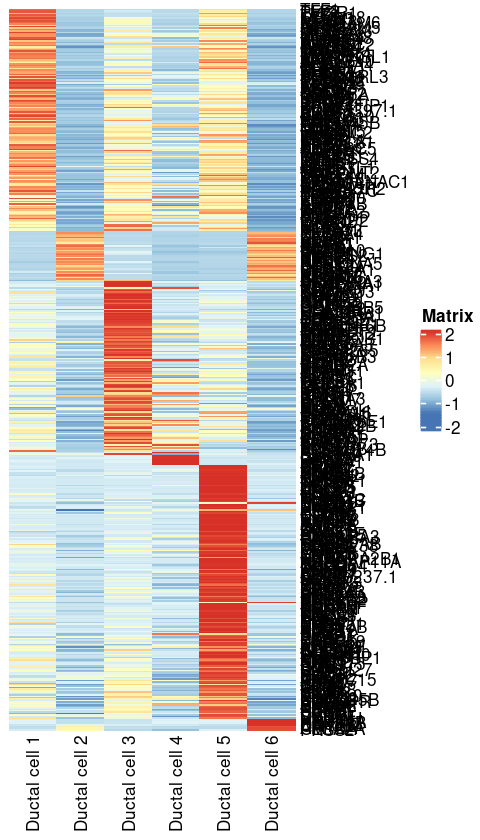

In [355]:
pheatmap(avgExpPCs,border_color = NA,cluster_cols = F, cluster_rows = F)

png 
  2

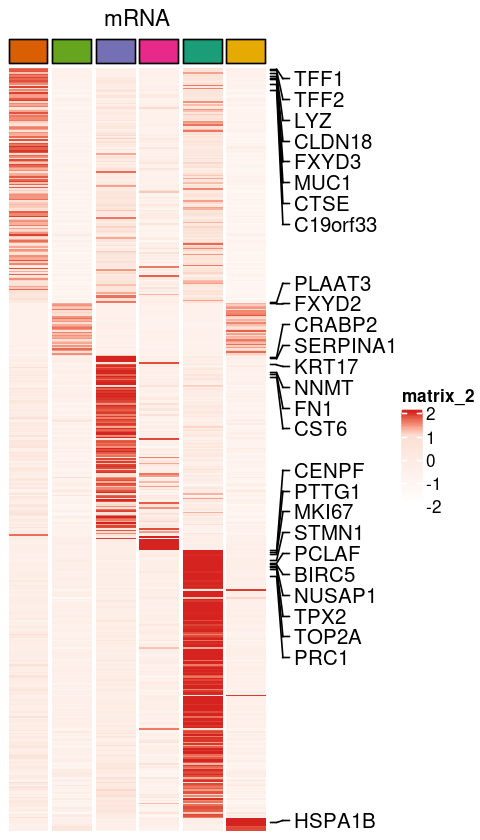

In [354]:
# 取top5%，用于展示在图右侧
primary_cluster_PCs %>% distinct(gene, .keep_all = TRUE) %>% group_by(cluster) %>% top_frac(0.05, pct.diff) %>% arrange(cluster) -> primary_cluster_PCs_top5
# 对有名的Lnc和top的去重，用于展示在图右侧
genesTmp <- avgExpPCs[which(rownames(avgExpPCs) %in% primary_cluster_PCs_top5$gene),]
genes_pos <- which(rownames(avgExpPCs) %in% rownames(genesTmp))

row_anno <- rowAnnotation(gene=anno_mark(at=genes_pos, labels = rownames(genesTmp)))
ha = HeatmapAnnotation(cluster = anno_block(gp = gpar(fill = legend_colors[1:6])))
options(repr.plot.width=4, repr.plot.height=7)
Heatmap(avgExpPCs,
        cluster_rows = FALSE,
        cluster_columns = FALSE,
        show_column_names = FALSE,
        show_row_names = FALSE,
        column_split = colnames(avgExpPCs),
        column_title = "mRNA",
        top_annotation = ha,
        right_annotation = row_anno,
        col = colorRamp2(c(-2, 1, 2), c("white","#fbe0d4", "#d5231f"))) -> h1

h1
pdf("/mnt/public3/chaohy/pancancer/fig3/Fig3b1.pdf",width=4,height=7)
h1
dev.off()

png 
  2

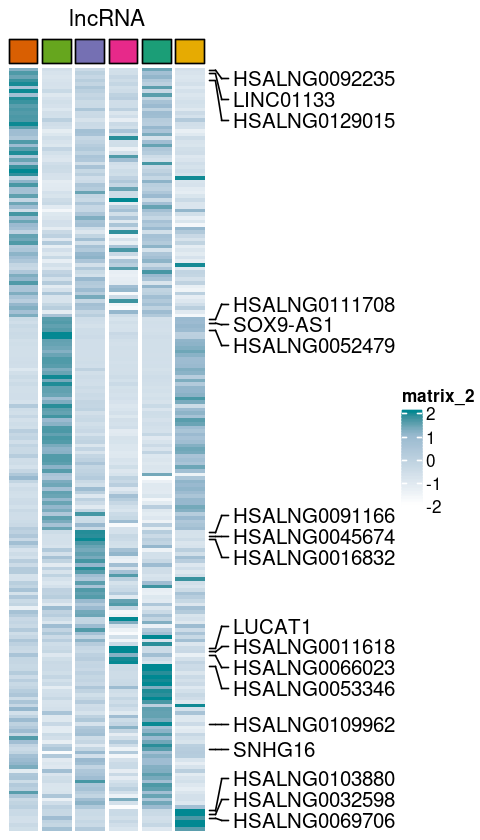

In [8]:
# 取top2，用于展示在图右侧
# primary_cluster_Lnc %>% dplyr::filter(!grepl("HSALNG",gene)) %>% distinct(gene, .keep_all = TRUE) %>% group_by(cluster) %>% top_n(2, pct.diff) %>% arrange(cluster) -> primary_cluster_Lnc_top2
primary_cluster_Lnc %>% distinct(gene, .keep_all = TRUE) %>% group_by(cluster) %>% top_n(3, pct.diff) %>% arrange(cluster) -> primary_cluster_Lnc_top5
# 对有名的Lnc和top的去重，用于展示在图右侧
genesTmp <- avgExpLnc[which(rownames(avgExpLnc) %in% primary_cluster_Lnc_top5$gene),]
genes_pos <- which(rownames(avgExpLnc) %in% rownames(genesTmp))

row_anno <- rowAnnotation(gene=anno_mark(at=genes_pos, labels = rownames(genesTmp)))
ha = HeatmapAnnotation(cluster = anno_block(gp = gpar(fill = legend_colors[1:6])))
options(repr.plot.width=4, repr.plot.height=7)
Heatmap(avgExpLnc,
        cluster_rows = FALSE,
        cluster_columns = FALSE,
        show_column_names = FALSE,
        show_row_names = FALSE,
        column_split = colnames(avgExpLnc),
        column_title = "lncRNA",
        top_annotation = ha,
        right_annotation = row_anno,
        col = colorRamp2(c(-2, 1, 2), c("white","#99b9cf", "#008892"))) -> h2

h2
pdf("/mnt/public3/chaohy/pancancer/fig3/Fig3b2.pdf",width=4,height=7)
h2
dev.off()

In [59]:
legend_labels <- c("Ductal cell 1", "Ductal cell 2", "Ductal cell 3", "Ductal cell 4", "Ductal cell 5", "Ductal cell 6", "HM", "PT", "NT")
markers_gene <- c("FXYD2", "HSPA1B", "AGR2", "MUC1", "FXYD3", "MMP7", "KRT17", "EPCAM", "MKI67", "CENPF")

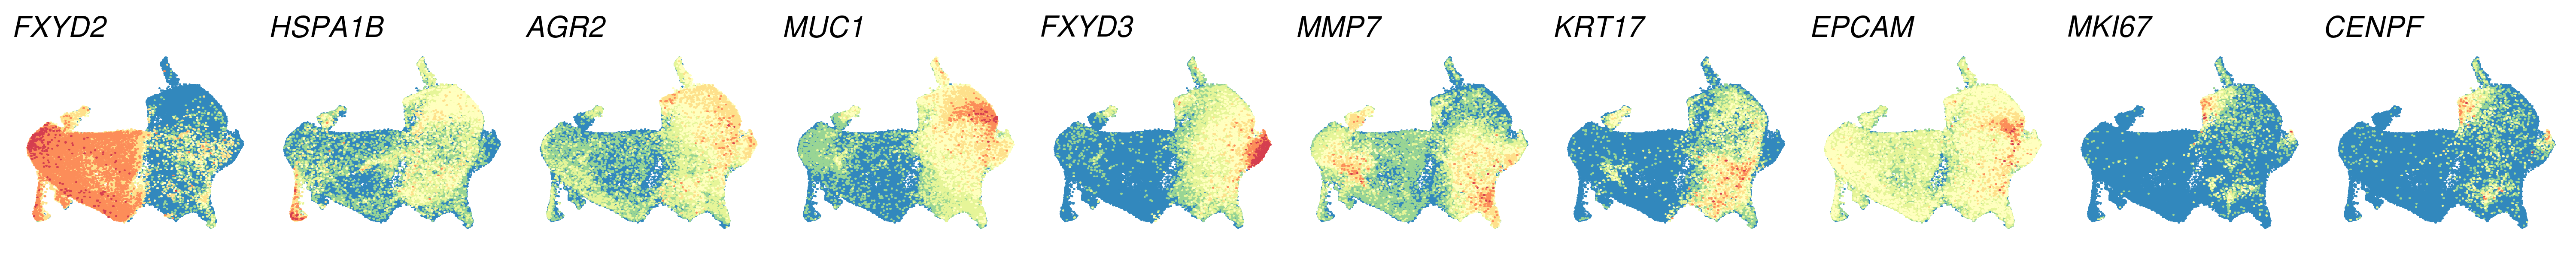

In [60]:
plots <- map(markers_gene, function(gene) {
  FeaturePlot(rds, features = gene, reduction = 'umap', order = TRUE, 
              cols = rev(brewer.spectral(7)), combine = TRUE, pt.size = 2, raster = TRUE) +
    NoLegend() +
    theme(axis.line = element_blank(), axis.text = element_blank(), 
          axis.ticks = element_blank(), axis.title = element_blank()) +
    labs(title = bquote(italic(.(gene)))) +
    theme(plot.title = element_text(hjust = 0, vjust = 0, size = 40))
})

options(repr.plot.width = 5*length(markers_gene), repr.plot.height = 5)
# 合并为一行
combined_plot <- wrap_plots(plots, ncol = length(markers_gene))
# 显示合并后的图
print(combined_plot)

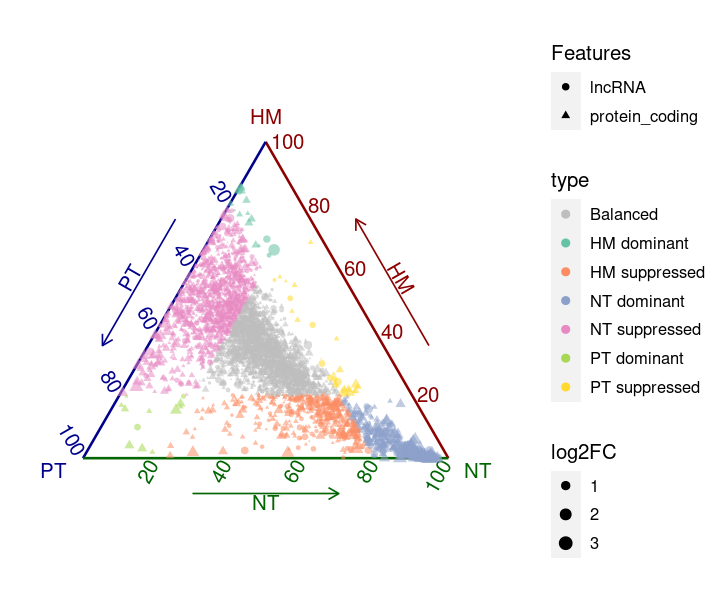

In [87]:
library(ggtern)

data_test_df_perc <- read.table("/mnt/public3/chaohy/pancancer/fig3/sanyuantuData.txt", header = T, sep = "\t", check.names = F)

gene_bed <- read.table("/mnt/public3/chaohy/pancancer/fig1c/gene.bed", sep="\t", header=F)
gene_bed[gene_bed$V5=="lncRNA",] -> gene_bed_lncRNA
gene_bed[gene_bed$V5=="protein_coding",] -> gene_bed_PC

data_test_df_perc$Features <- "protein_coding"
data_test_df_perc$log2FC <- as.numeric(data_test_df_perc$log2FC)

for(i in 1:nrow(gene_bed_lncRNA)){
  data_test_df_perc[which(data_test_df_perc$gene == gene_bed_lncRNA$V4[i]),'Features'] <- gene_bed_lncRNA$V5[i]}
 
options(repr.plot.width=6, repr.plot.height=5)

ggtern(data_test_df_perc, aes(x=PT, y=HM, z=NT,color=type)) + geom_mask() + 
  geom_point(aes(size=log2FC,alpha=0.8,shape=Features)) +
  scale_size(range = c(0, 3)) +
  scale_color_manual(values = c("grey",pals::brewer.set2(6)))+
  guides(alpha = "none",position="bottom") +
  theme_rgbw() +
  theme(axis.text=element_blank(), axis.ticks=element_blank()) -> p


Warning message:
“Removed 10 rows containing non-finite values (`stat_boxplot()`).”
Warning message:
“Removed 10 rows containing non-finite values (`stat_boxplot()`).”


png 
  2

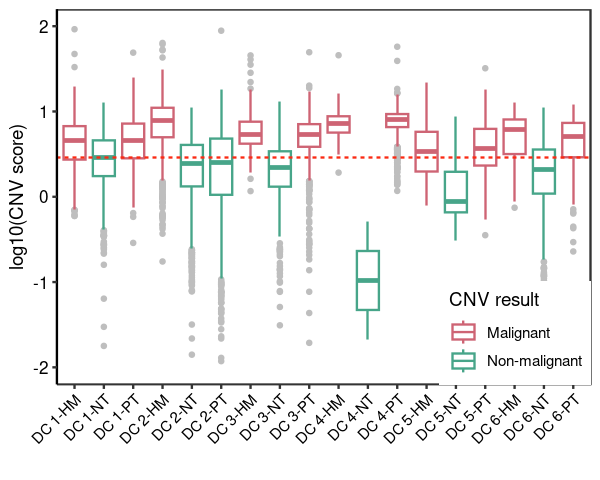

In [9]:
# 箱型图1，以恶性非恶性为分类
inputdata <- read.table("/mnt/public3/chaohy/pancancer/fig3/infercnvscore.txt", sep = "\t", header = T, check.names = F)

ggplot(inputdata, aes(x = Celltypeyu, y = log10(CNV_score), color = CNV_result)) +
  geom_boxplot(outlier.color = "grey", outlier.size = 0.8, size = 0.5) +
  xlab("") +
  ylab("log10(CNV score)") +
  theme_bw() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1,color = "black")) +
  guides(fill = guide_legend(nrow = 3, byrow = T)) +
  geom_hline(yintercept = 0.465, linetype = "dashed", color = "#fa2a13", size = 0.5) + ylim(-2, 2) + # 设置 y 轴范围
  theme(legend.position = "right")+
  theme(panel.grid = element_blank(),
        axis.line.y = element_line(color = "black"), # 仅显示 y 轴线
        axis.text.y = element_text(size = 10,color = "black"),
        legend.position = c(1, 0), legend.justification = c(1, 0))+
  scale_color_manual(values = c("#ce6474","#47a589"), name = "CNV result") -> p8

options(repr.plot.width=5, repr.plot.height=4)
p8
pdf("/mnt/public3/chaohy/pancancer/fig3/Fig3c8.pdf",width=5,height=4)
p8    
dev.off()

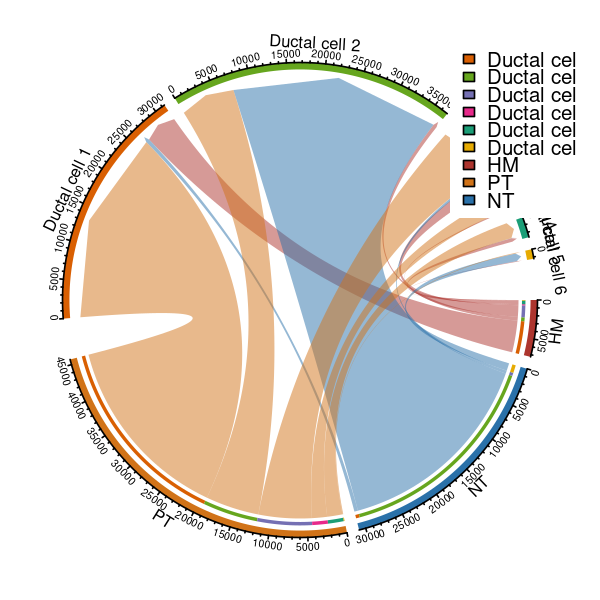

In [205]:
library(circlize)
chordDiagram <- read.table("/mnt/public3/chaohy/pancancer/fig3/chordDiagram.txt", sep = "\t", header = T, check.names = F)
circos.clear()
gap.size <- c( rep(3, 2), 10,rep(3, 5), 10)
circos.par(gap.after = gap.size)
grid.col <- c("Ductal cell 1" = "#d95f02", "Ductal cell 2" = "#66a61e", "Ductal cell 3" = "#7570b3",
              "Ductal cell 4"= "#e7298a", "Ductal cell 5" = "#1b9e77", "Ductal cell 6" = "#e6ab02",
              HM = "#AD352E", PT = "#D17318", NT = "#2a71a9")

options(repr.plot.width=5, repr.plot.height=5)
# pdf("/mnt/public3/chaohy/pancancer/fig3/fig3cirs", height=4, width=4)
chordDiagram(chordDiagram, directional =1, grid.col = grid.col,
             direction.type = c("diffHeight", "arrows"),
             link.arr.type = "big.arrow")
legend("topright", legend=legend_labels, fill=legend_colors, title="",box.lty=0)
# dev.off()

In [ ]:
library(tidyverse)
library(igraph)

In [358]:
cor_threshold <- 0.5

mp1 <- read.table("/mnt/public3/chaohy/pancancer/fig3/igraph/cluster3_meta_gene_list.txt", sep = "\t", header = TRUE, check.names = FALSE)
rds@assays$SCT@data[rownames(rds@assays$SCT@data) %in% mp1[,1],] %>% t() %>% as.data.frame() -> mp1_exp
cor(mp1_exp) %>% as.data.frame() %>% rownames_to_column() %>% gather(key = "gene2", value = "cor", -rowname) -> mp1_cor
mp1_cor %>% dplyr::filter(abs(cor) > cor_threshold & cor < 1) %>% distinct(cor, .keep_all = TRUE) %>% arrange(desc(cor)) -> mp1_cor_top
data.frame(rowname = "MP1", gene2 = unique(c(mp1_cor_top$rowname, mp1_cor_top$gene2)), cor = "1") -> MP1
rbind(mp1_cor_top, MP1) -> mp1_cor_top

mp2 <- read.table("/mnt/public3/chaohy/pancancer/fig3/igraph/cluster1_meta_gene_list.txt", sep = "\t", header = TRUE, check.names = FALSE)
rds@assays$SCT@data[rownames(rds@assays$SCT@data) %in% mp2[,1],] %>% t() %>% as.data.frame() -> mp2_exp
cor(mp2_exp) %>% as.data.frame() %>% rownames_to_column() %>% gather(key = "gene2", value = "cor", -rowname) -> mp2_cor
mp2_cor %>% dplyr::filter(abs(cor) > cor_threshold & cor < 1) %>% distinct(cor, .keep_all = TRUE) %>% arrange(desc(cor)) -> mp2_cor_top
data.frame(rowname = "MP2", gene2 = unique(c(mp2_cor_top$rowname, mp2_cor_top$gene2)), cor = "1") -> MP2
rbind(mp2_cor_top, MP2) -> mp2_cor_top

mp3 <- read.table("/mnt/public3/chaohy/pancancer/fig3/igraph/cluster4_meta_gene_list.txt", sep = "\t", header = TRUE, check.names = FALSE)
rds@assays$SCT@data[rownames(rds@assays$SCT@data) %in% mp3[,1],] %>% t() %>% as.data.frame() -> mp3_exp
cor(mp3_exp) %>% as.data.frame() %>% rownames_to_column() %>% gather(key = "gene2", value = "cor", -rowname) -> mp3_cor
mp3_cor %>% dplyr::filter(abs(cor) > cor_threshold & cor < 1) %>% distinct(cor, .keep_all = TRUE) %>% arrange(desc(cor)) -> mp3_cor_top
data.frame(rowname = "MP3", gene2 = unique(c(mp3_cor_top$rowname, mp3_cor_top$gene2)), cor = "1") -> MP3
rbind(mp3_cor_top, MP3) -> mp3_cor_top

mp4 <- read.table("/mnt/public3/chaohy/pancancer/fig3/igraph/cluster5_meta_gene_list.txt", sep = "\t", header = TRUE, check.names = FALSE)
rds@assays$SCT@data[rownames(rds@assays$SCT@data) %in% mp4[,1],] %>% t() %>% as.data.frame() -> mp4_exp
cor(mp4_exp) %>% as.data.frame() %>% rownames_to_column() %>% gather(key = "gene2", value = "cor", -rowname) -> mp4_cor
mp4_cor %>% dplyr::filter(abs(cor) > cor_threshold & cor < 1) %>% distinct(cor, .keep_all = TRUE) %>% arrange(desc(cor)) -> mp4_cor_top
data.frame(rowname = "MP4", gene2 = unique(c(mp4_cor_top$rowname, mp4_cor_top$gene2)), cor = "1") -> MP4
rbind(mp4_cor_top, MP4) -> mp4_cor_top

In [359]:
rbind(mp1_cor_top, mp2_cor_top, mp3_cor_top, mp4_cor_top) -> cor_top
rbind(MP1, MP2, MP3, MP4) -> MP

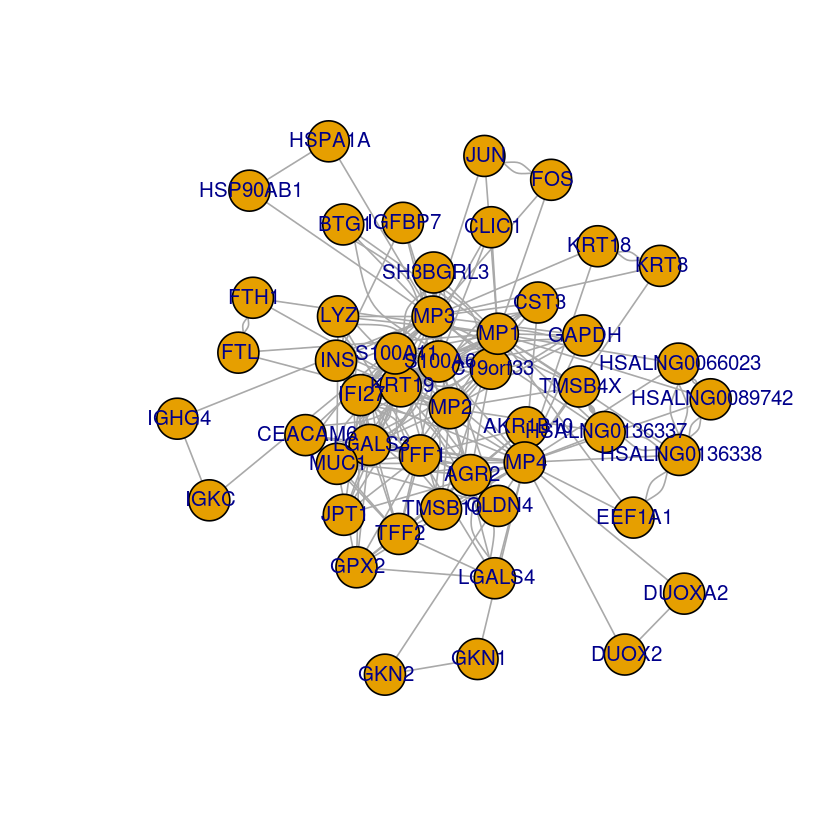

In [362]:
nodes <- unique(c(cor_top$rowname, cor_top$gene2))
nodes <- mutate(data.frame(nodes), id = 1:length(nodes)) # 可以为点添加各种属性
colnames(nodes)<-c("label","location")

edges <- cor_top[, 1:3] %>% rename(from=rowname,to=gene2,weight=cor)

# 创建一个igraph对象
net_pc<-graph_from_data_frame(
   d=edges,
   vertices=nodes,
   directed=F)


options(repr.plot.width=7, repr.plot.height=7)
plot(net_pc,
# vertex.size=degree(net_pc,mode="all"), # 设置节点的大小
vertex.label.cex=1, # 设置节点标签的字体大小
vertex.label.dist=0.1, # 设置节点标签和点的距离
# edge.color="gray50", # 设置边的颜色
# edge.arrow.size=.7, # 设置箭头的大小
# edge.curved=.2, # 设置边的弯曲程度
layout=layout_with_lgl(net_pc) # 设置图形的布局
)


In [332]:
head(MP)
head(gene_bed_lncRNA)

,rowname,gene2,cor
,<chr>,<chr>,<chr>
1,MP1,C19orf33,1
2,MP1,S100A6,1
3,MP1,KRT19,1
4,MP1,TFF1,1
5,MP1,HSALNG0089742,1
6,MP1,IFI27,1


,V1,V2,V3,V4,V5
,<chr>,<int>,<int>,<chr>,<chr>
1,chr1,29369,34369,HSALNG0000002,lncRNA
2,chr1,17750,22750,HSALNG0000003,lncRNA
4,chr1,25939,30939,HSALNG0000004,lncRNA
5,chr1,24553,29553,HSALNG0000005,lncRNA
7,chr1,36080,41080,HSALNG0000006,lncRNA
8,chr1,50391,55391,HSALNG0000007,lncRNA


In [351]:
read.table("/mnt/public3/chaohy/pancancer/fig2/gene.bed", sep="\t", header=F) -> gene_bed
gene_bed[gene_bed$V5=="lncRNA",] -> gene_bed_lncRNA

rbind(MP1, MP2, MP3, MP4) -> MP
MP$type <- ifelse(MP$gene2 %in% gene_bed_lncRNA$V4, "lncRNA", "mRNA")
colnames(MP) <- c("source","target","cor","type")
write.csv(MP, file = "/mnt/public3/chaohy/pancancer/fig3/igraph/MP.csv", quote = F, row.names = F)

# 如果是lncRNA，就标记为lncRNA，否则标记为mRNA（注意会误伤MP的label）
nodes <- unique(c(cor_top$rowname, cor_top$gene2))
nodes <- mutate(data.frame(nodes), id = 1:length(nodes)) 
colnames(nodes)<-c("label","location")
nodes$location <- nodes$label
nodes$type <- ifelse(nodes$label %in% gene_bed_lncRNA$V4, "lncRNA", "mRNA")
colnames(nodes) <- c("ID","Label","Type")
write.csv(nodes, file = "/mnt/public3/chaohy/pancancer/fig3/igraph/nodes.csv", quote = F, row.names = F)